In [369]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt

## Data Generation Functions

In [498]:
class Context:
    def __init__(self, ndim, u):
        self.ndim = ndim
        self.u = u
        self.contextWeights = np.ones(ndim)
        self.noise = np.zeros(ndim)
    def set_contextWeights(self, weights):
        self.contextWeights = weights
    def set_noise(self, noise):
        self.noise = np.array(list(map(abs, noise)))
    def degrade_u(self):
        self.u = np.multiply(self.contextWeights, self.u)
        for i in range(self.ndim):
            self.u[i] = np.random.normal(self.u[i], self.noise[i], 1)
        self.u = self.u.clip(min=0)

#### Context Initialization

In [523]:
Y_MEAN, Y_SIGMA = 1.5, 0.5
SIGMA = 0.02
ADMINVAR = 1.0
DECAY = 0.033
NDIM = 6
# clotting factors concentrate: Factor VIII
# anticoagulant: warfarin
# vitamin K amounts in mcg
# indicator on particular chronic condition
# platelet transfusion in ml/kg
initial_u = np.array([20, 10, 42, 120, 2, 10])
context = Context(NDIM, initial_u)
contextWeights = np.array([0.865, 0.96, 1, 0.93, 1, 0.94])
noise = np.array([0.4, 0.02, 0, 3, 0, 0.05])
context.set_contextWeights(contextWeights)
context.set_noise(noise)
a = np.array([0.04,0.02,0.02,-0.01,0.06,-0.06])

In [524]:
def transition(a, u, y_prev):
    y_t = np.max([0, np.random.normal(np.dot(u,a)+y_prev, SIGMA, 1)])
    return y_t

# exponential decay on likelihood of intervention
def indicate_administration(y_t, tdiff):
    decay = (np.e ** (-DECAY * tdiff))
    p = (1-decay) * scipy.stats.norm(Y_MEAN, Y_SIGMA).cdf(y_t)
    flag = random.random() < p
    return flag

def administer(a, context):
    u_t = np.zeros(context.ndim)
    for i in range(context.ndim):
        u_t[i] = np.random.normal(initial_u[i], context.noise[i], 1)
    u_t = u_t.clip(min=0)
    y_t = np.max([0, np.random.normal(Y_MEAN, ADMINVAR, 1)])
    return y_t, u_t

In [525]:
def run_simulation(time_length, a, y0, context):
    U = np.zeros((time_length, context.ndim))
    y = np.zeros(time_length)
    U[0,:], y[0] = context.u, y0
    adminstered = []
    tlast = 0
    for t in range(1, time_length):
        context.degrade_u()
        y_t = transition(a, context.u, y[t-1])
        if indicate_administration(y_t, t-tlast):
            y_t, context.u = administer(a, context)
            adminstered.append(t)
            tlast = t
        U[t,:] = context.u
        y[t] = y_t
    return U, y, adminstered

#### Visualize INR trajectories and concurrent interventions

In [526]:
def plot_trajectory(y, administered):
    times = list(range(len(y)))
    plt.plot(times, y, 'ro')
    plt.xlabel('time (hr)')
    plt.ylabel('INR')
    plt.title('observed INR trajectory and interventions')
    for t in administered:
        plt.axvline(x=t, color='g', linestyle='--')
    plt.show()

#### Example

In [527]:
U, y, administered = run_simulation(80, a, 1.5, context)

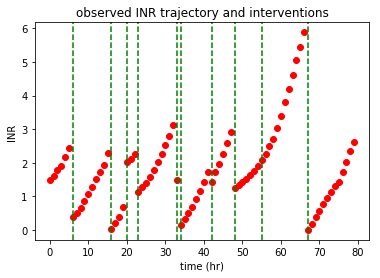

In [528]:
plot_trajectory(y, administered)

The dashed green lines mark manual interventions where the control inputs are brought down to a regular level.